---
title: IDs from Juno
---

See following notebooks for details:

- [Magnetic field data](./mag.ipynb)
- [State data](./state.ipynb)

## Background

Spacecraft-Solar equatorial

https://pds-ppi.igpp.ucla.edu/data/JNO-SS-3-FGM-CAL-V1.0/INDEX/INDEX.TAB


```txt
------------------------------------------------------------------------------
Juno Mission Phases                                                           
------------------------------------------------------------------------------
Start       Mission                                                           
Date        Phase                                                             
==============================================================================
2011-08-05  Launch                                                            
2011-08-08  Inner Cruise 1                                                    
2011-10-10  Inner Cruise 2                                                    
2013-05-28  Inner Cruise 3                                                    
2013-11-05  Quiet Cruise                                                      
2016-01-05  Jupiter Approach                                                  
2016-06-30  Jupiter Orbital Insertion                                         
2016-07-05  Capture Orbit                                                     
2016-10-19  Period Reduction Maneuver                                         
2016-10-20  Orbits 1-2                                                        
2016-11-09  Science Orbits                                                    
2017-10-11  Deorbit
```

### Coordinate System of Data

1. **SE (Solar Equatorial)**
    - Code: `se`
    - Resampling options: 
        - Number of seconds (1 or 60): `se_rN[N]s`
        - Resampled 1 hour: `se_r1h`

2. **PC (Planetocentric)**
    - Code: `pc`
    - Resampling options: 
        - Number of seconds (1 or 60): `pc_rN[N]s`
        
3. **SS (Sun-State)**
    - Code: `ss`
    - Resampling options: 
        - Number of seconds (1 or 60): `ss_rN[N]s`
        
4. **PL (Payload)**
    - Code: `pl`
    - Resampling options: 
        - Number of seconds (1 or 60): `pl_rN[N]s`

There are three principal coordinate systems used to represent the data in this archive.

- The SE coordinate system is a Spacecraft- Solar equatorial system and it will be used for cruise data only. 
- The sun-state (ss) and planetocentric (pc) will be used for Earth Fly By (EFB) and Jupiter orbital data. 
- Cartesian representations are used for all three coordinate systems. These coordinate systems are specified relative to a “target body” which may be any solar system object (but for this orbital operations will Jupiter). In what follows we will reference Jupiter as the target body, but, for example, if observations near a satellite (such as Io) are desired in Io-centric coordinates, the satellite Io may be specified as the target body. 

The SE coordinate system is defined using the sun-spacecraft vector as the primary reference vector; sun’s rotation axis as the secondary reference vector (z). The x axis lies along the sun-spacecraft vector, the z axis is in the plane defined by the Sun’s rotation axis and the spacecraft-sun vector. The y axis completes the system.

The ss coordinate system is defined using the instantaneous Jupiter-Sun vector as the primary reference vector (x direction). The X-axis lies along this vector and is taken to be positive toward the Sun. The Jupiter orbital velocity vector is the second vector used to define the coordinate system; the y axis lies in the plane determined by the Jupiter-Sun vector and the velocity vector and is orthogonal to the x axis (very nearly the negative of the velocity vector). The vector cross product of x and y yields a vector z parallel to the northward (upward) normal of the orbit plane of Jupiter. This system is sometimes called a sun-state (ss) coordinate system since its principal vectors are the Sun vector and the Jupiter state vector.

## Setup

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
from discontinuitypy.datasets import IDsDataset
import polars as pl
from fastcore.utils import walk
from loguru import logger

from datetime import timedelta

In [18]:
mission = "JNO"
ts = timedelta(seconds=1)
tau = timedelta(seconds=60)


data_dir = '../../../data'
dir_path = f'{data_dir}/03_primary/JNO_MAG_ts_{ts.seconds}s'
juno_state_path = f'{data_dir}/03_primary/JNO_STATE_ts_3600s.parquet'
vec_cols = ['v_x', 'v_y', 'v_z']

format = 'arrow'
fname = f'events.{mission}.ts_{ts.total_seconds():.2f}s_tau_{tau.seconds}s.{format}'
output_path = f'{data_dir}/05_reporting/{fname}'

In [ ]:
plasma_data = pl.scan_parquet(juno_state_path).sort('time')
logger.info(plasma_data.columns)

In [ ]:
juno_events = []
for mag_path in walk(dir_path):
    juno_mag_data = pl.scan_parquet(mag_path).drop('X', 'Y', 'Z').sort('time')

    _juno_events = (
        IDsDataset(
            mag_data=juno_mag_data,
            plasma_data=plasma_data,
            tau=tau,
            ts=ts,
            vec_cols=vec_cols,
            density_col="plasma_density",
            speed_col="plasma_speed",
            temperature_col="plasma_temperature",
        )
        .find_events(return_best_fit=False)
        .update_candidates_with_plasma_data()
        .events
    )
    
    juno_events.append(_juno_events)
    
juno_ids_dataset = IDsDataset(
    events=pl.concat(juno_events),
    mag_data= pl.scan_parquet(list(walk(dir_path))).drop('X', 'Y', 'Z').sort('time')
).export(output_path)

## Check the discontinuity in the last year of Juno cruise phase

### First year

In [19]:
mag_path = sorted(list(walk(dir_path)))[0]
tau = timedelta(seconds=60)
juno_mag_data = pl.scan_parquet(mag_path).drop('X', 'Y', 'Z').sort('time')

ids_ds = (
    IDsDataset(
        mag_data=juno_mag_data,
        plasma_data=plasma_data,
        tau=tau,
        ts=ts,
        vec_cols=vec_cols,
        density_col="plasma_density",
        speed_col="plasma_speed",
        temperature_col="plasma_temperature",
    )
    .find_events(return_best_fit=True)
    .update_candidates_with_plasma_data()
)

17-Feb-24 15:09:08: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.

17-Feb-24 15:09:08: DeprecationWarning: `map_alias` is deprecated. It has been moved to `name.map`.

17-Feb-24 15:09:08: DeprecationWarning: `map_alias` is deprecated. It has been moved to `name.map`.

17-Feb-24 15:09:10: UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.



Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 15:   0%           Elapsed time: 00:00, estimated remaining time: ?

17-Feb-24 15:09:39: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

17-Feb-24 15:09:39: DeprecationWarning: `nanoseconds` is deprecated. It has been renamed to `total_nanoseconds`.

17-Feb-24 15:09:39: PendingDeprecationWarning: The `dims` argument has been renamed to `dim`, and will be removed in the future. This renaming is taking place throughout xarray over the next few releases.

17-Feb-24 15:09:39: PendingDeprecationWarning: The `dims` argument has been renamed to `dim`, and will be removed in the future. This renaming is taking place throughout xarray over the next few releases.

17-Feb-24 15:09:39: PendingDeprecationWarning: The `dims` argument has been renamed to `dim`, and will be removed in the future. This renaming is taking place throughout xarray over the next few releases.

17-Feb-24 15:09:39: Depr

2024-02-17 15:09:51.206 | INFO     | discontinuitypy.datasets:plot_candidates:215 - Candidates indices: [10436  8841 13616  9794   120 11659  3392  3969  8190  2869 13639 11070
  4853 13902  8554  9970 11430  8080   723  8650]


[(<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: -0.06, $R^2$: 0.96, $\\chi^2$: 0.13'}, ylabel='$B$\n[nT LMN]'>),
 (<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: 0.17, $R^2$: 0.98, $\\chi^2$: 0.05'}, ylabel='$B$\n[nT LMN]'>),
 (<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: -0.98, $R^2$: 0.99, $\\chi^2$: 0.15'}, ylabel='$B$\n[nT LMN]'>),
 (<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: 0.73, $R^2$: 0.97, $\\chi^2$: 1.86'}, ylabel='$B$\n[nT LMN]'>),
 (<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: 0.23, $R^2$: 0.99, $\\chi^2$: 0.06'}, ylabel='$B$\n[nT LMN]'>),
 (<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: -0.02, $R^2$: 0.99, $\\chi^2$: 0.01'}, ylabel='$B$\n[nT LMN]'>),
 (<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt

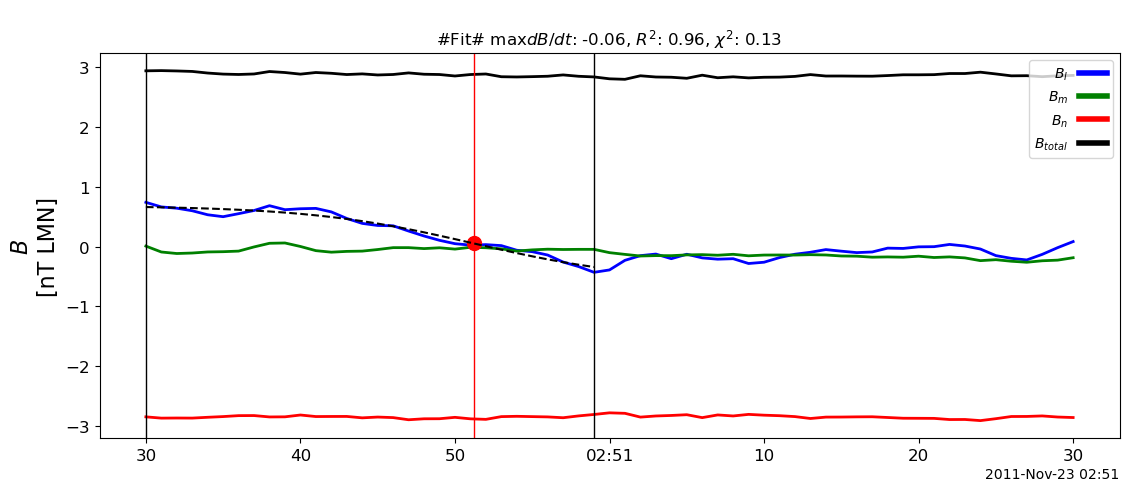

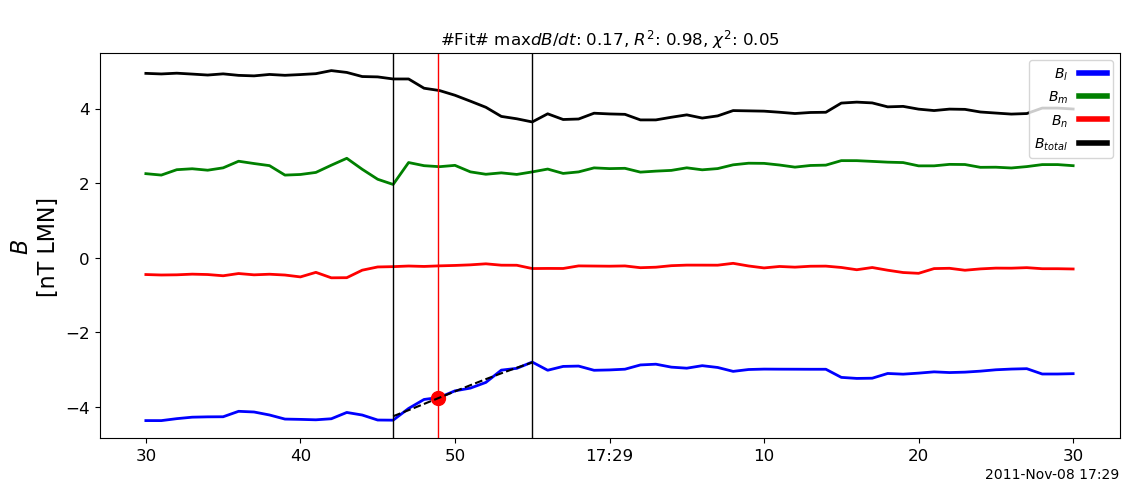

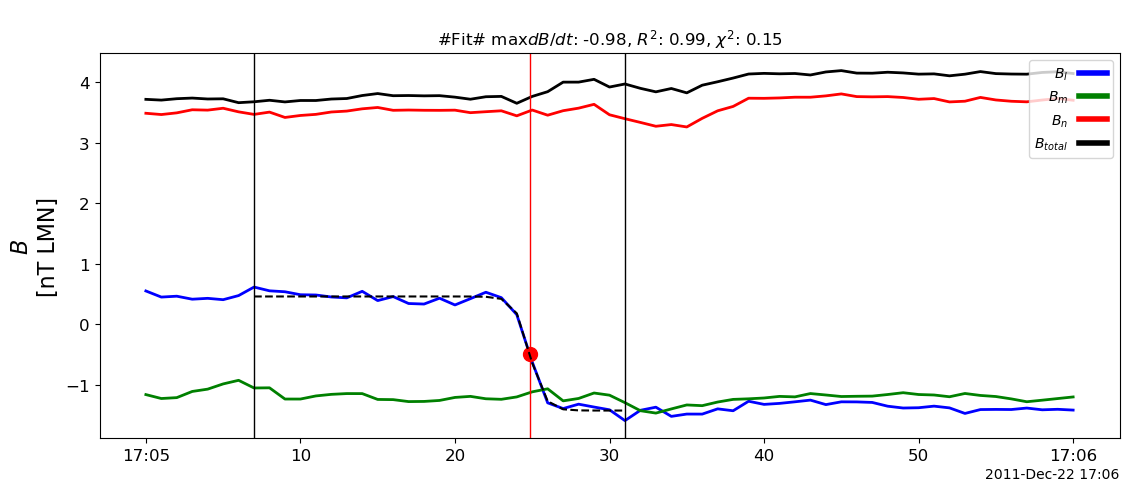

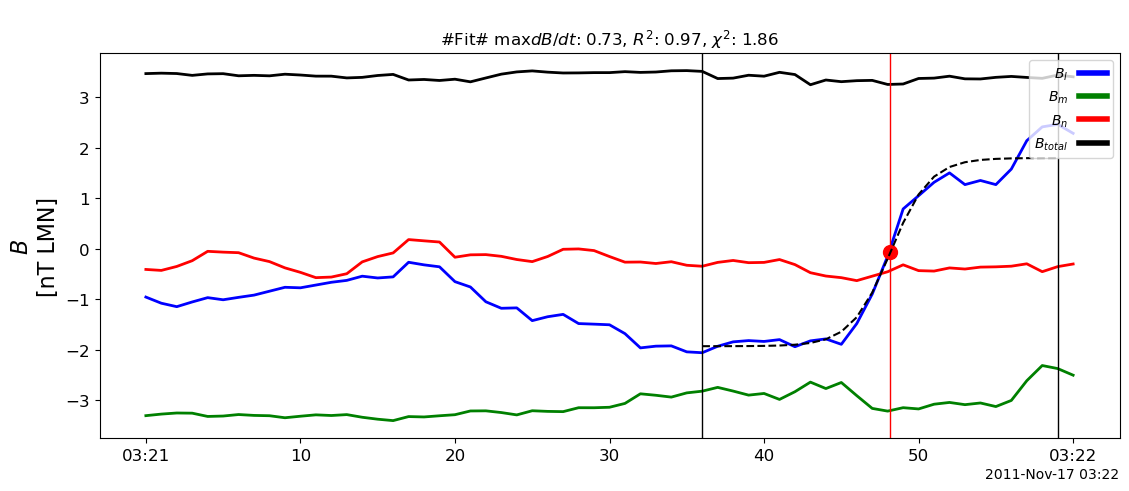

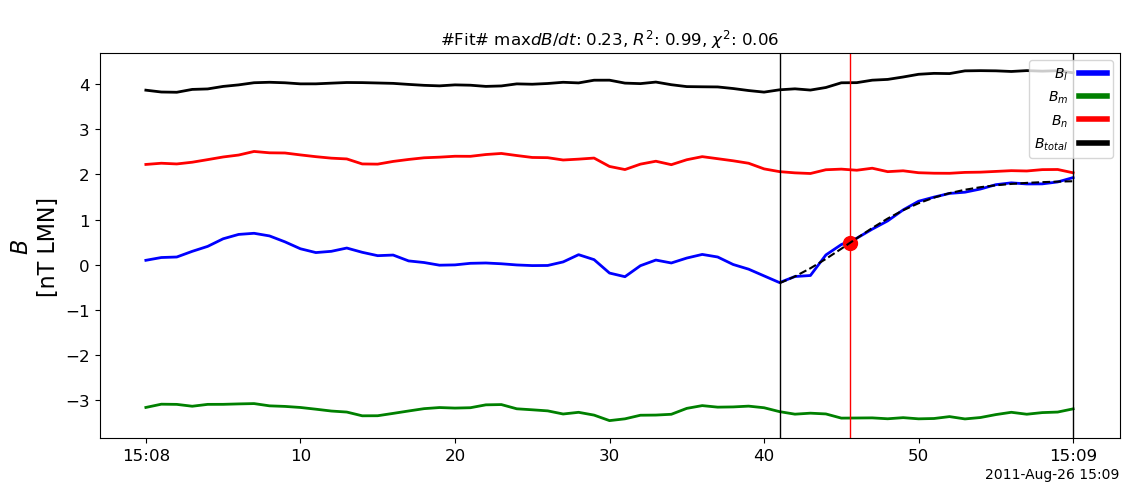

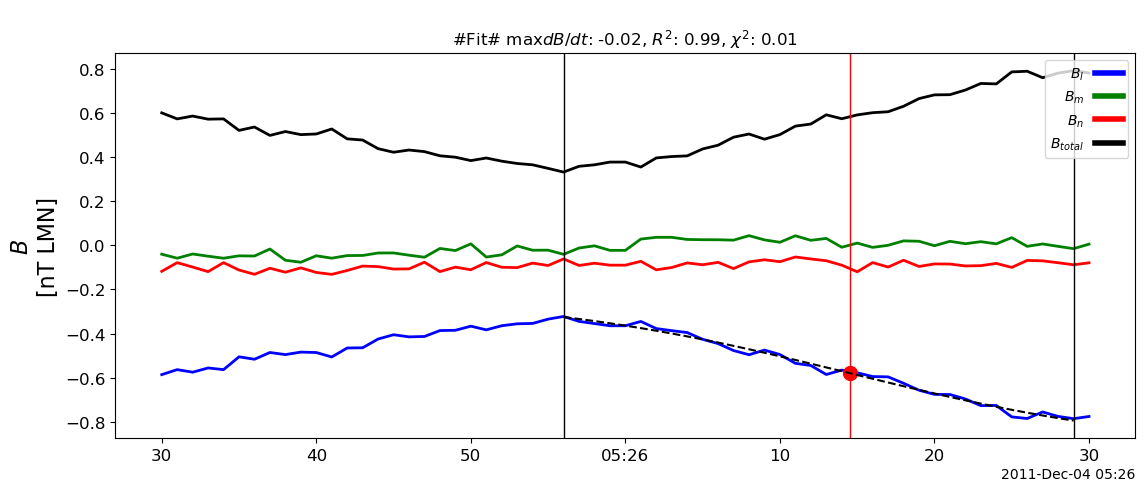

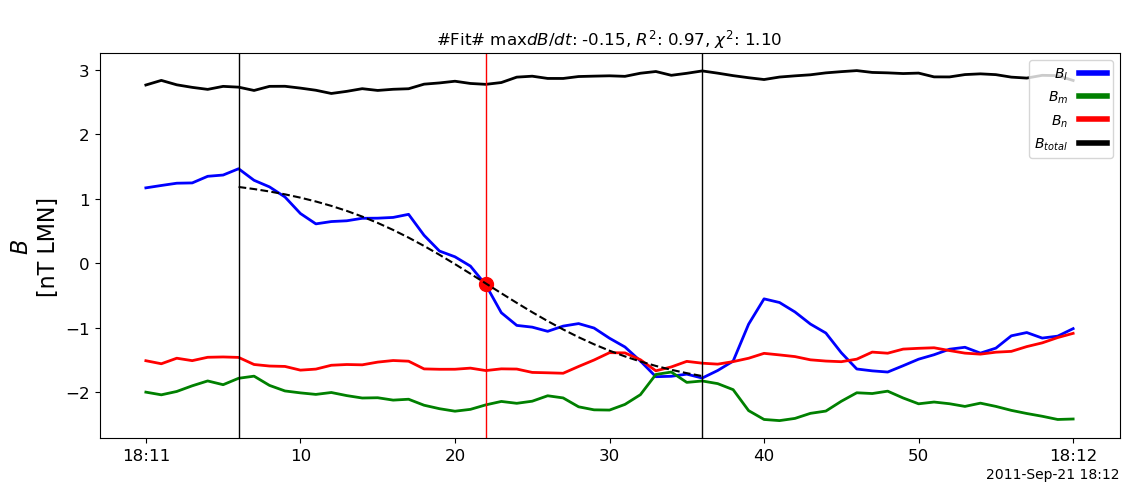

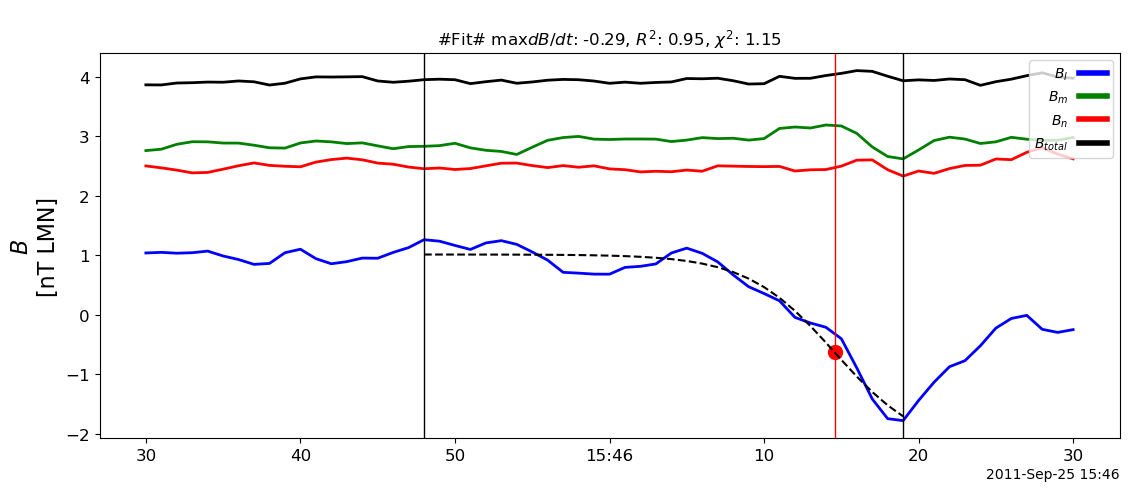

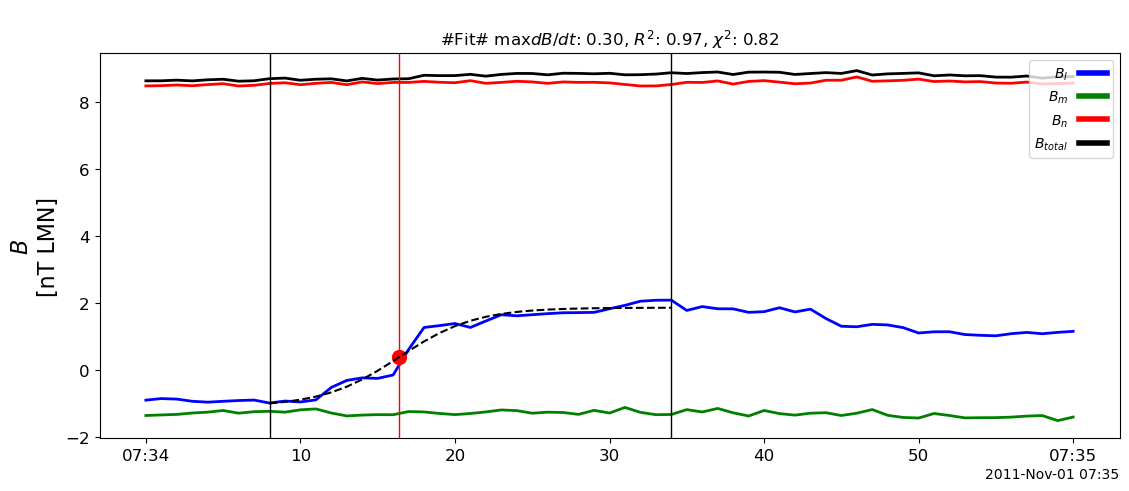

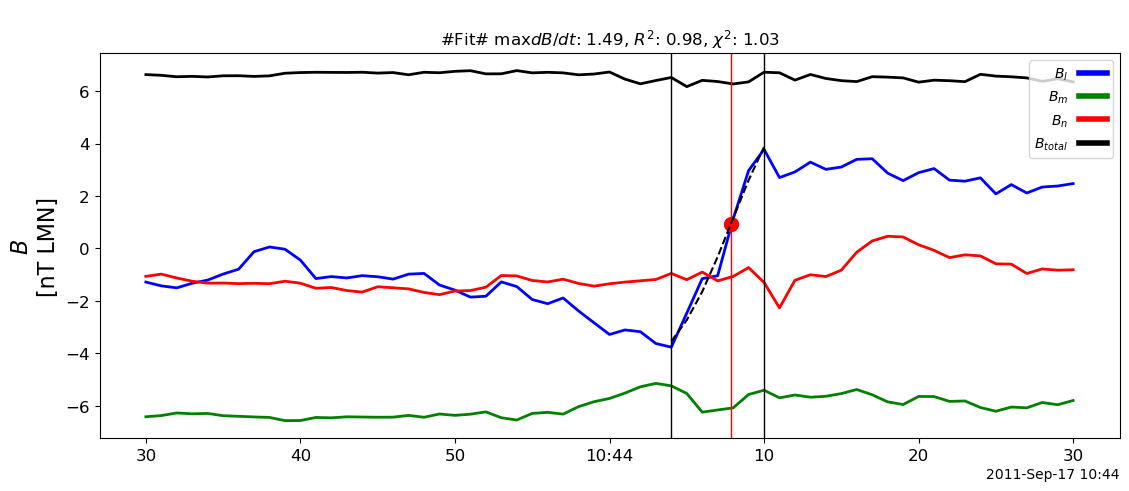

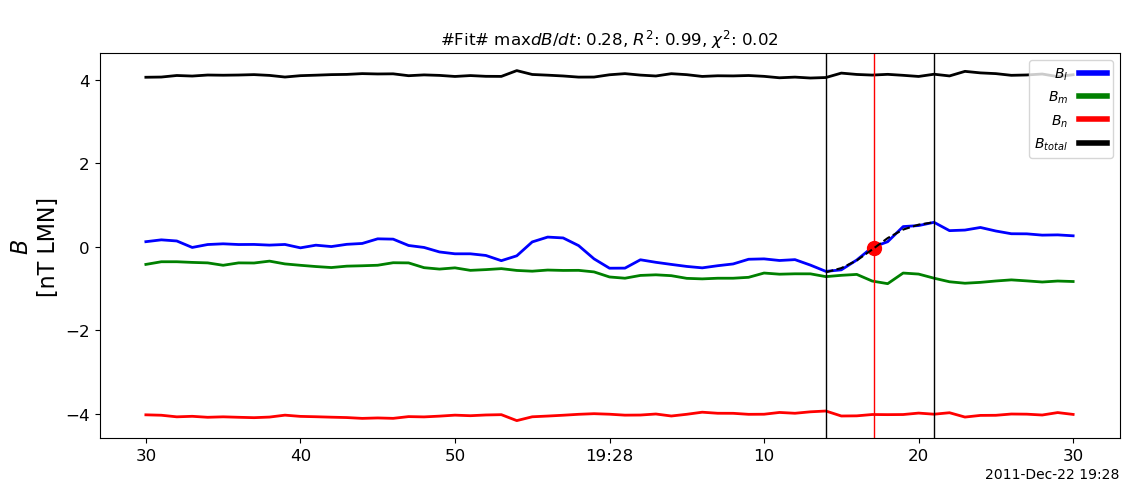

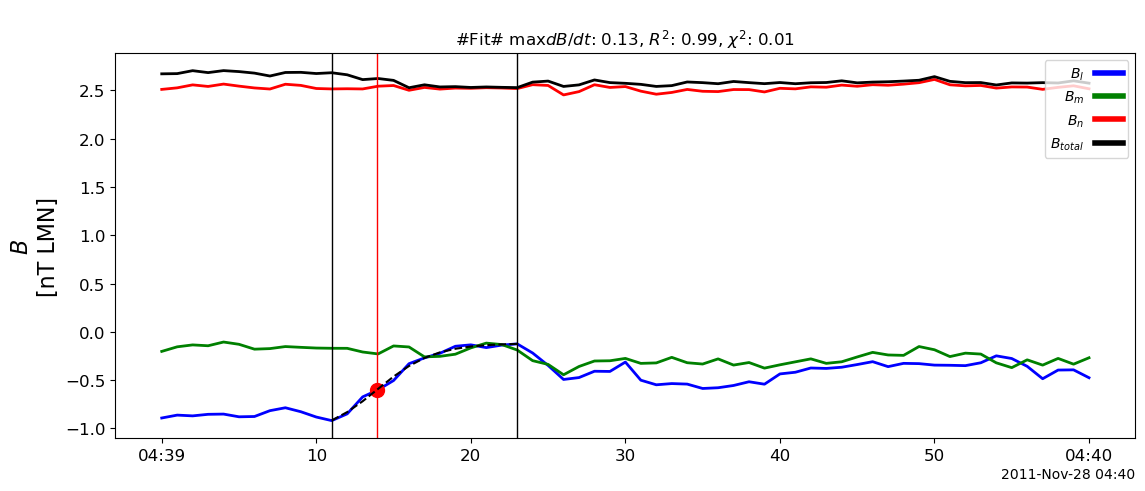

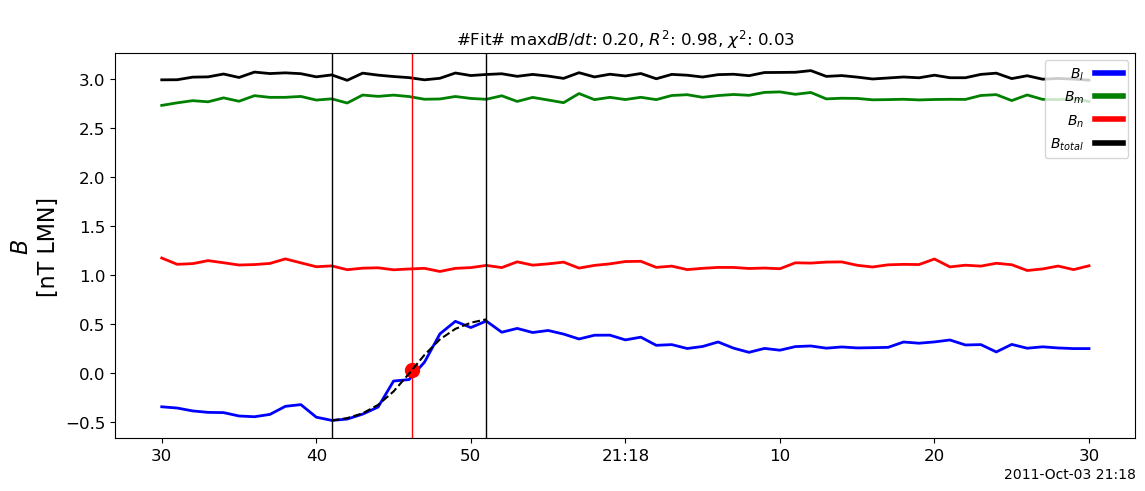

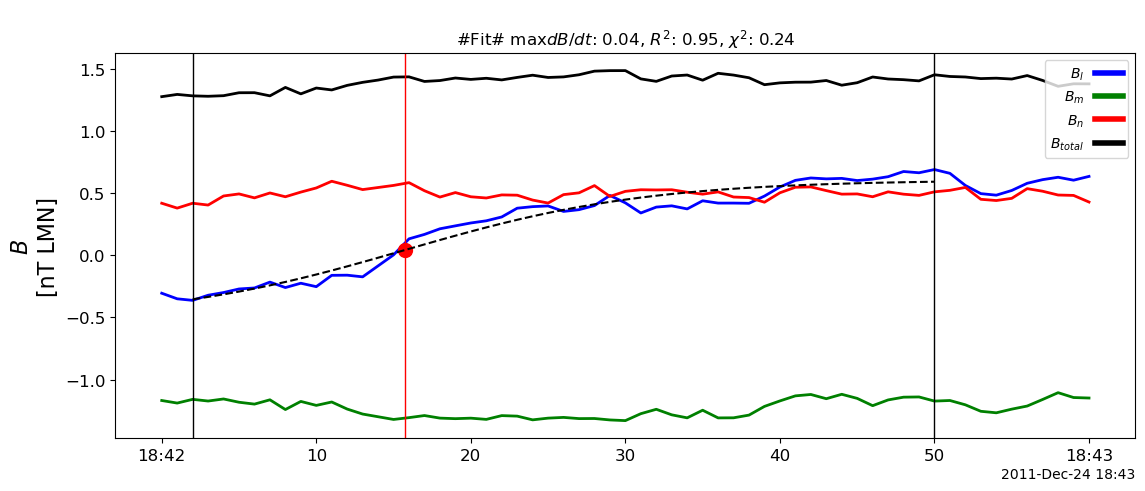

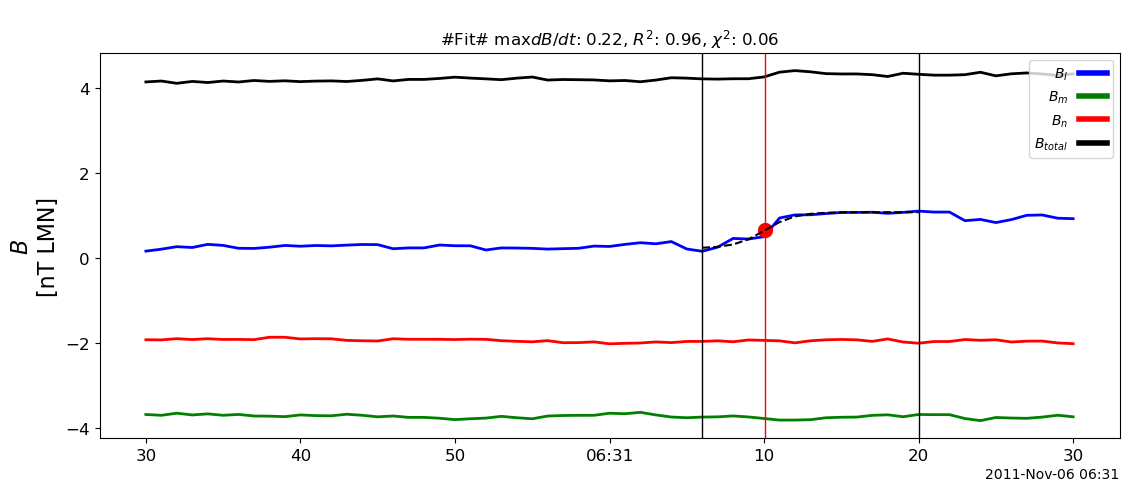

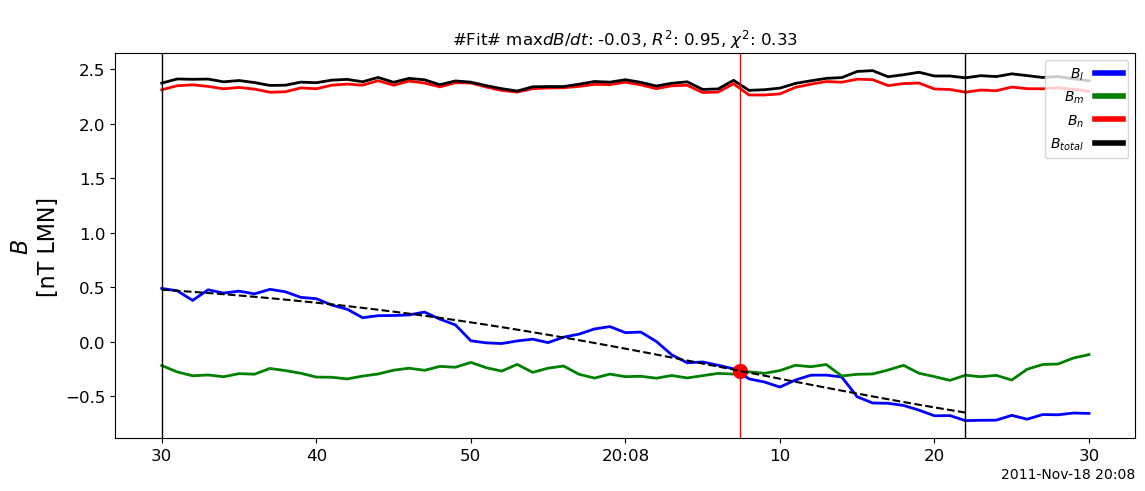

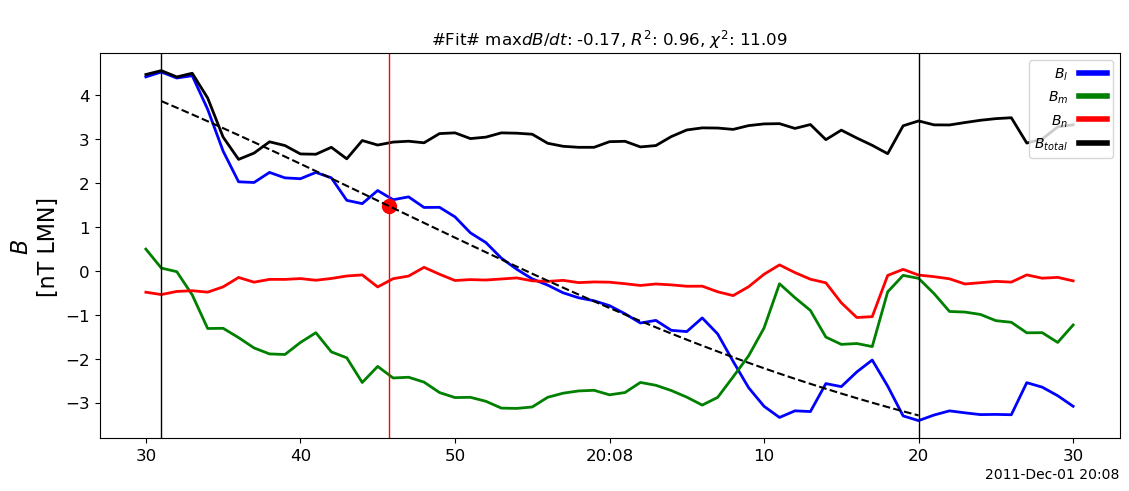

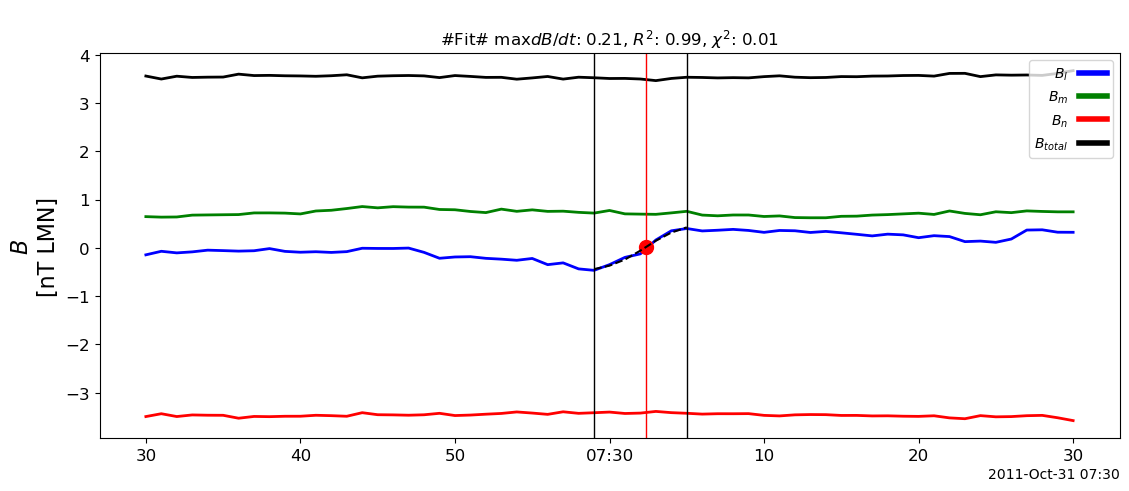

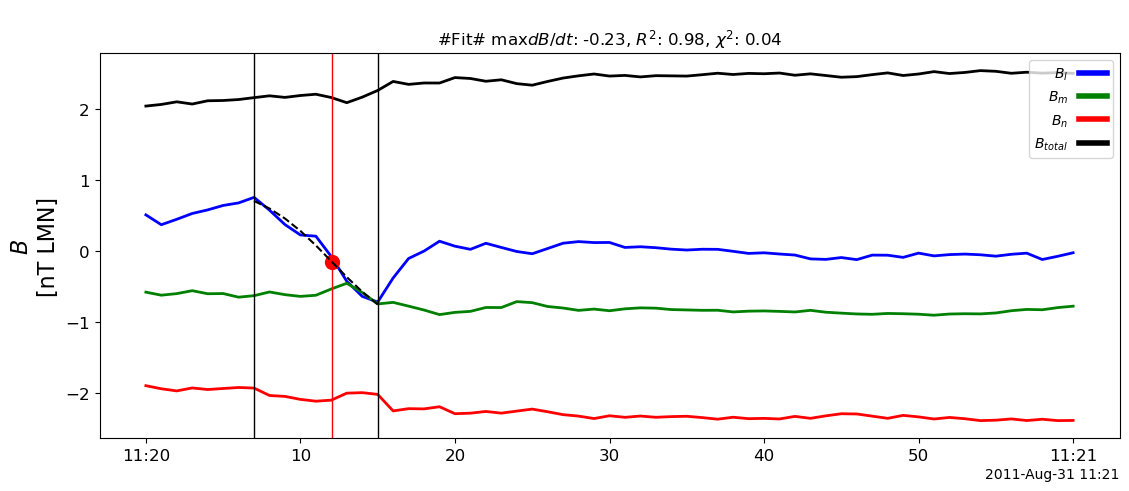

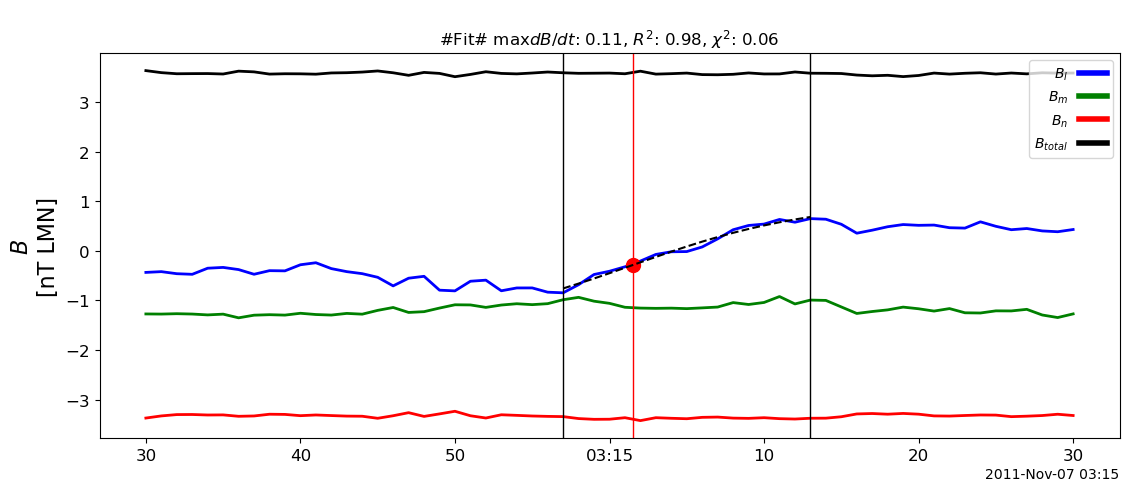

In [20]:
#| layout-ncol: 3
#| column: page
ids_ds.plot_candidates(num=20, plot_fit_data=True, predicates=(pl.col('fit.stat.rsquared') > 0.95))

### Last year

In [14]:
# mag_path = sorted(list(walk(dir_path)))[-1]
tau = timedelta(seconds=300)
mag_path = sorted(list(walk(dir_path)))[-1]
juno_mag_data = pl.scan_parquet(mag_path).drop('X', 'Y', 'Z').sort('time')

ids_ds = (
    IDsDataset(
        mag_data=juno_mag_data,
        plasma_data=plasma_data,
        tau=tau,
        ts=ts,
        vec_cols=vec_cols,
        density_col="plasma_density",
        speed_col="plasma_speed",
        temperature_col="plasma_temperature",
    )
    .find_events(return_best_fit=True)
    .update_candidates_with_plasma_data()
)

17-Feb-24 15:07:29: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.

17-Feb-24 15:07:29: DeprecationWarning: `map_alias` is deprecated. It has been moved to `name.map`.

17-Feb-24 15:07:29: DeprecationWarning: `map_alias` is deprecated. It has been moved to `name.map`.

17-Feb-24 15:07:31: UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.



Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 16:   0%           Elapsed time: 00:00, estimated remaining time: ?

17-Feb-24 15:07:36: DeprecationWarning: `nanoseconds` is deprecated. It has been renamed to `total_nanoseconds`.

17-Feb-24 15:07:36: PendingDeprecationWarning: The `dims` argument has been renamed to `dim`, and will be removed in the future. This renaming is taking place throughout xarray over the next few releases.

17-Feb-24 15:07:36: PendingDeprecationWarning: The `dims` argument has been renamed to `dim`, and will be removed in the future. This renaming is taking place throughout xarray over the next few releases.

17-Feb-24 15:07:36: PendingDeprecationWarning: The `dims` argument has been renamed to `dim`, and will be removed in the future. This renaming is taking place throughout xarray over the next few releases.

17-Feb-24 15:07:36: DeprecationWarning: `suffix` is deprecated. It has been moved to `name.suffix`.

17-Feb-24 15:07:36: DeprecationWarning: `suffix` is deprecated. It has been moved to `name.suffix`.

17-Feb-24 15:07:36: DeprecationWarning: `suffix` is deprecated. It

2024-02-17 15:07:37.771 | INFO     | discontinuitypy.datasets:plot_candidates:215 - Candidates indices: [1104  694 1238 1324  313  331 1240  790  689 1233   34  670  674 1045
 1439  411 1043  793    5  436]


[(<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: 0.02, $R^2$: 0.98, $\\chi^2$: 2.03'}, ylabel='$B$\n[nT LMN]'>),
 (<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: 0.17, $R^2$: 0.98, $\\chi^2$: 0.21'}, ylabel='$B$\n[nT LMN]'>),
 (<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: -0.07, $R^2$: 0.98, $\\chi^2$: 0.33'}, ylabel='$B$\n[nT LMN]'>),
 (<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: 0.02, $R^2$: 0.97, $\\chi^2$: 0.32'}, ylabel='$B$\n[nT LMN]'>),
 (<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: -0.11, $R^2$: 0.95, $\\chi^2$: 0.22'}, ylabel='$B$\n[nT LMN]'>),
 (<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$: 0.02, $R^2$: 0.96, $\\chi^2$: 0.81'}, ylabel='$B$\n[nT LMN]'>),
 (<Figure size 1200x500 with 1 Axes>,
  <Axes: title={'center': '\n#Fit# $\\max dB/dt$

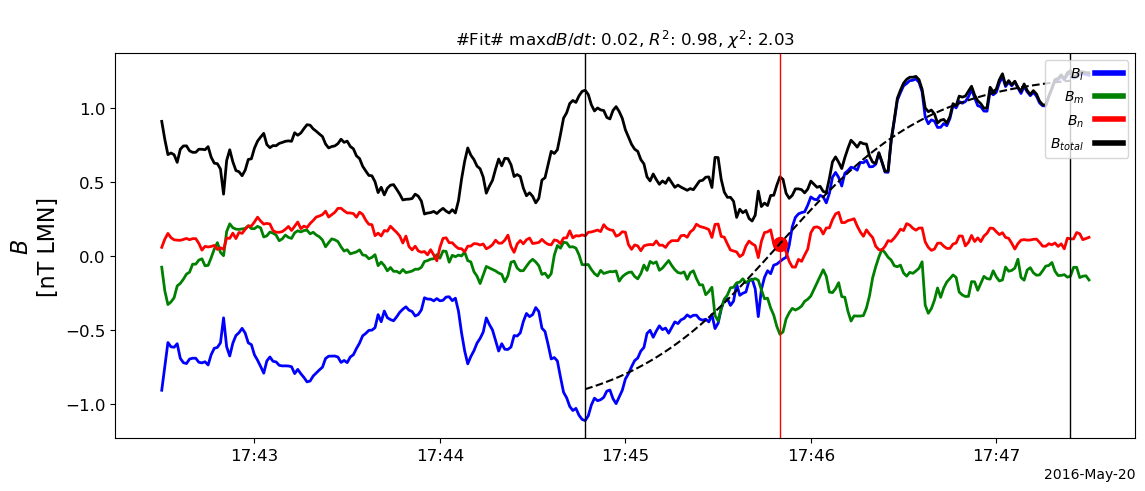

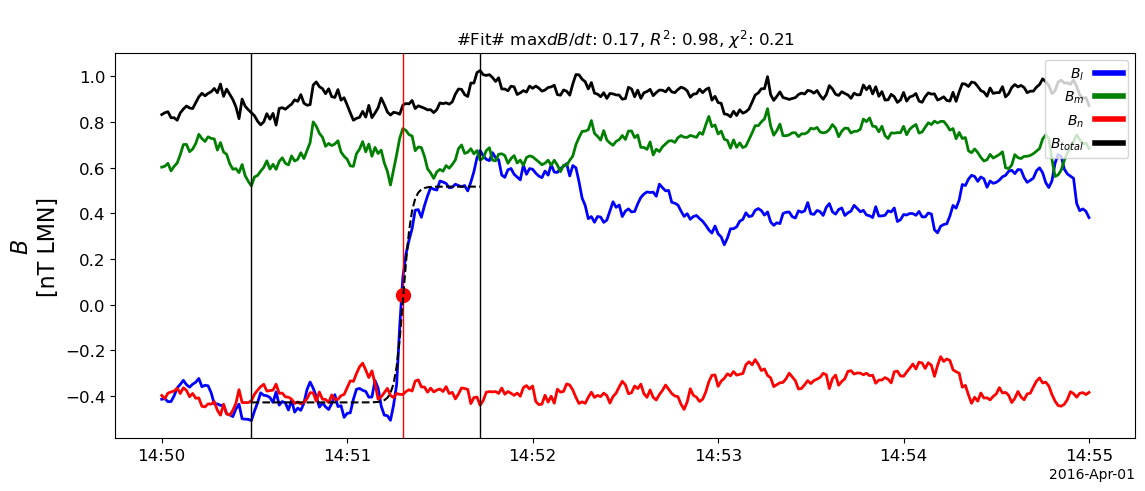

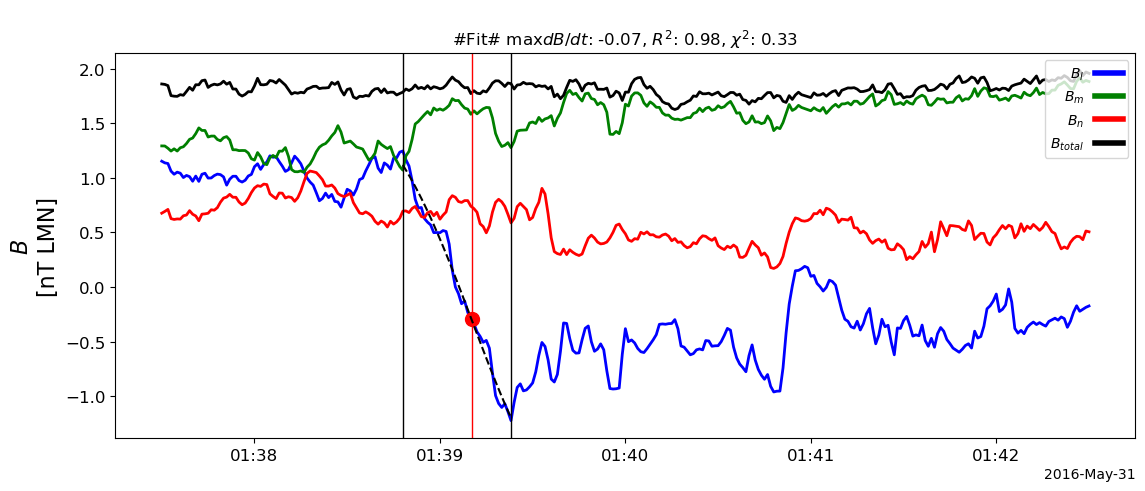

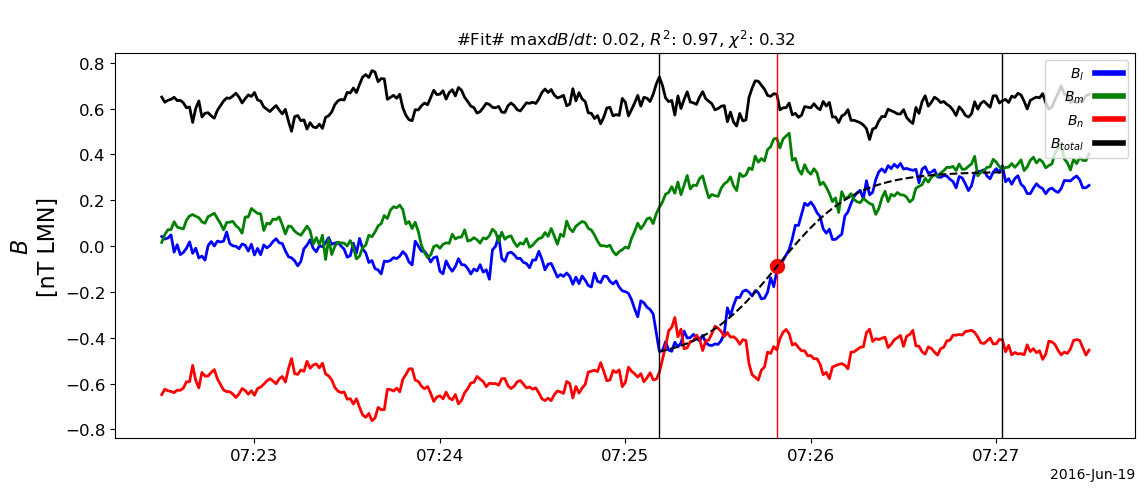

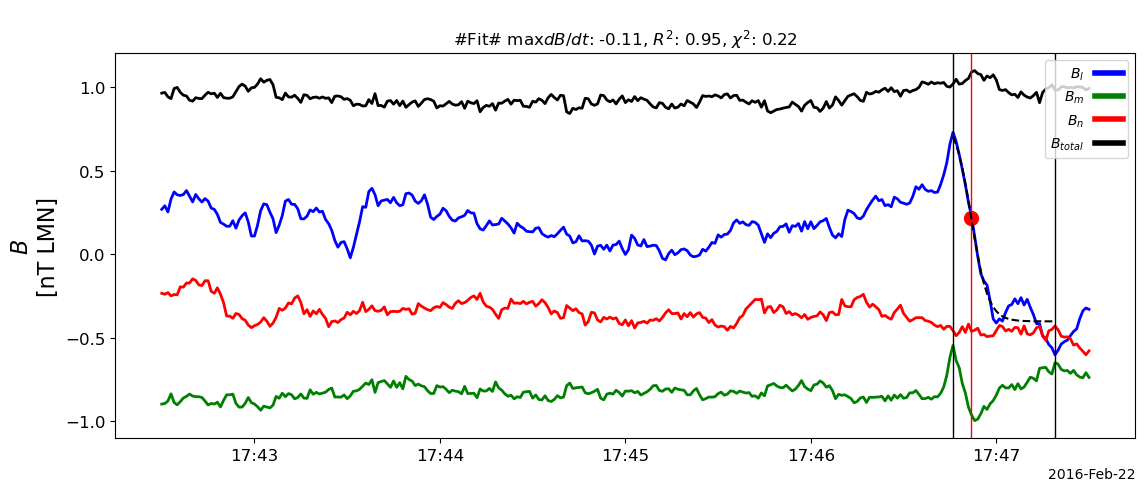

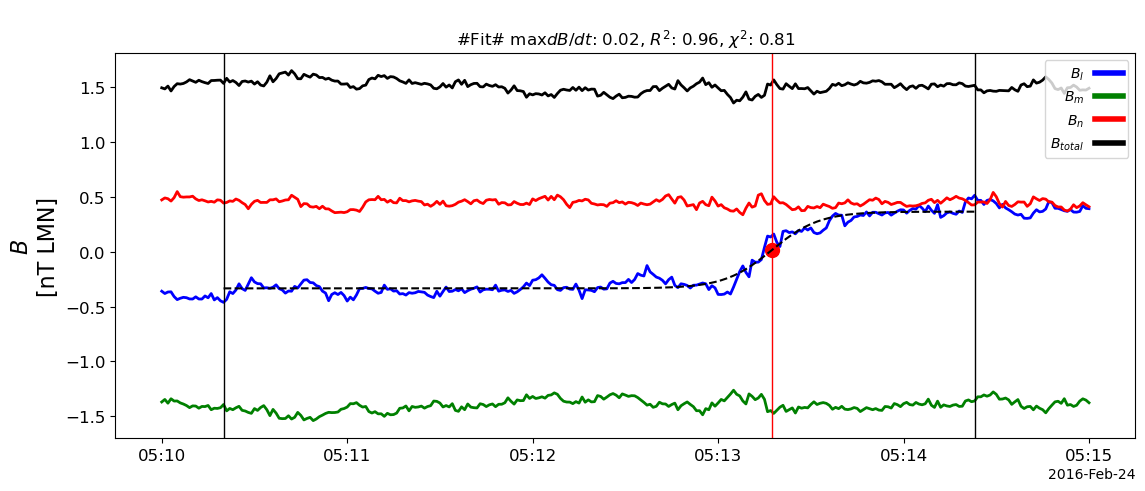

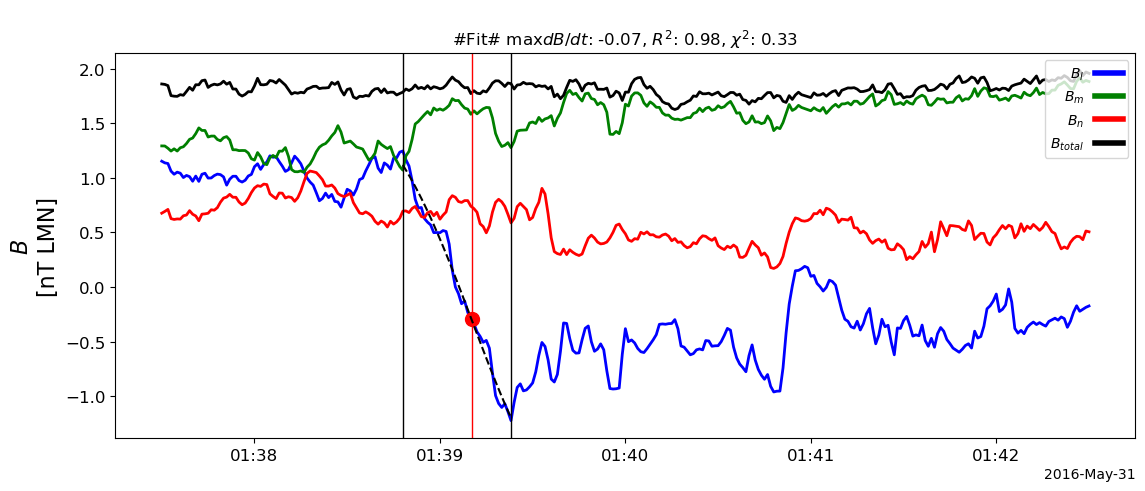

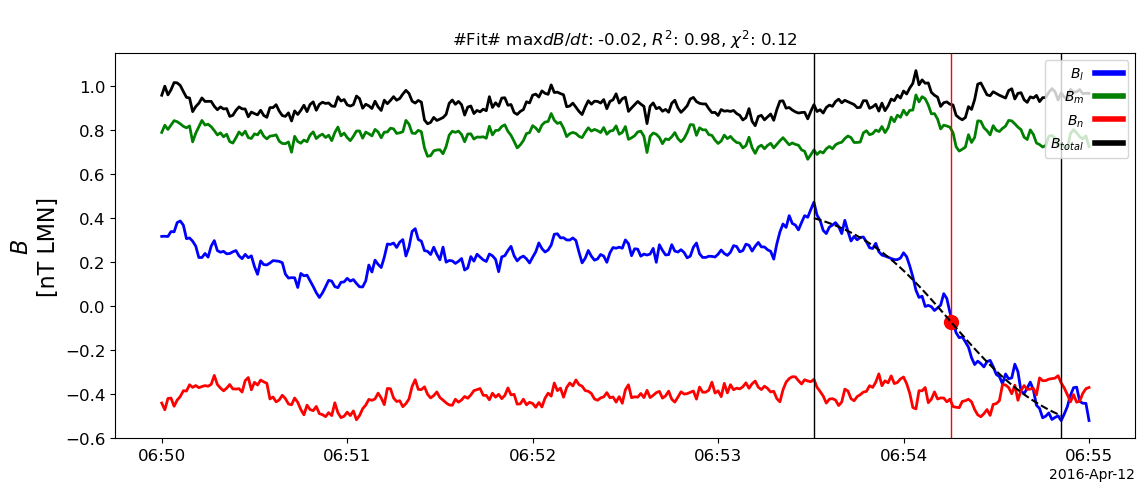

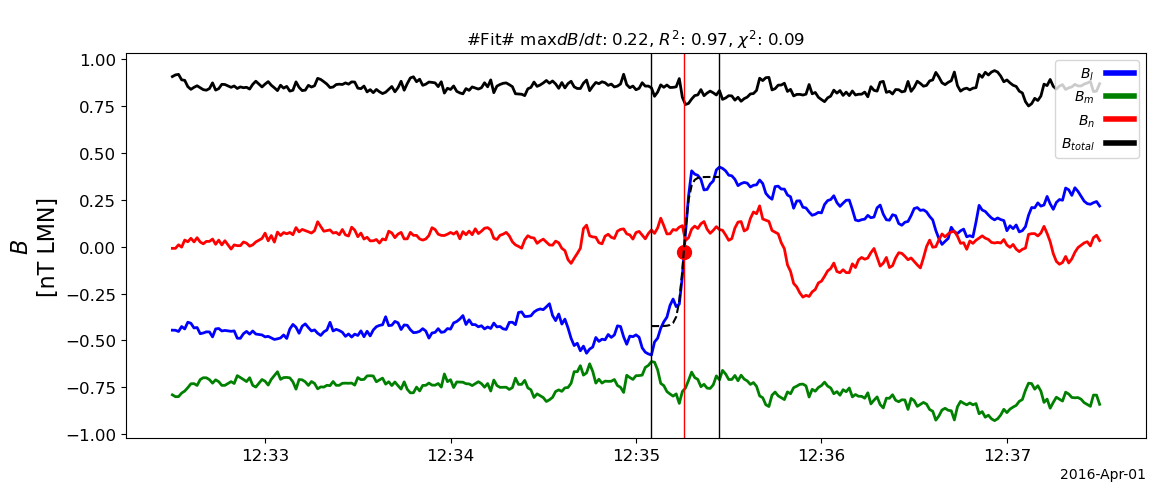

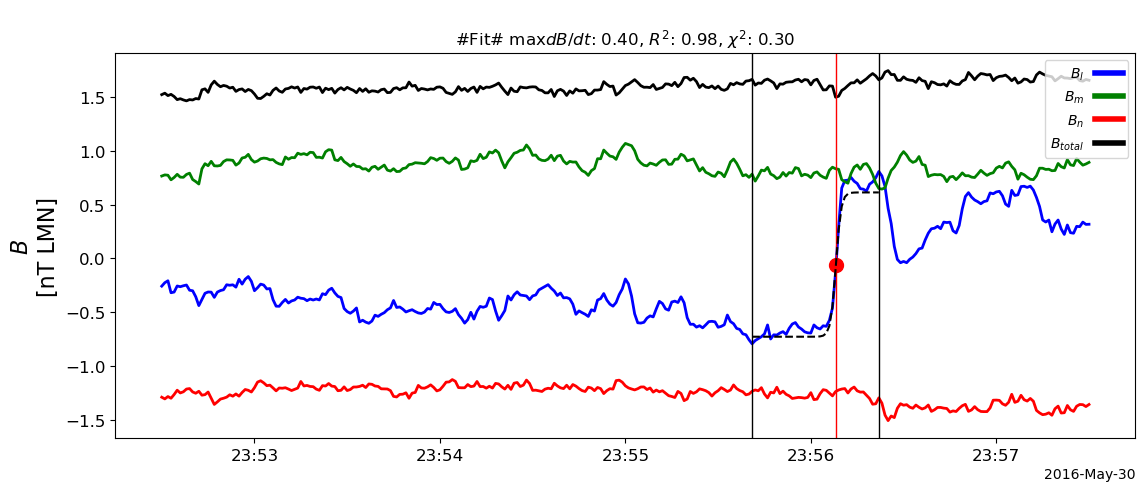

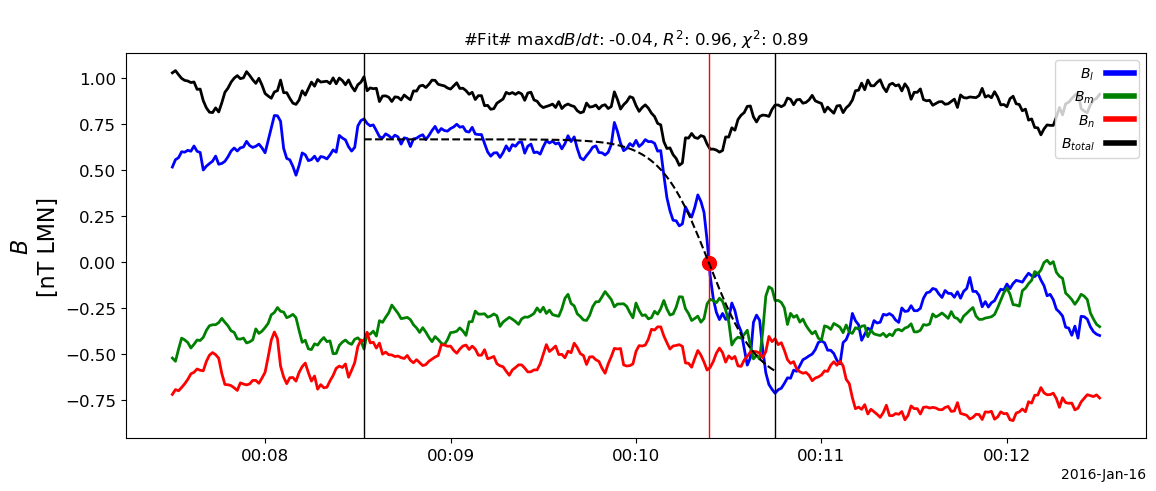

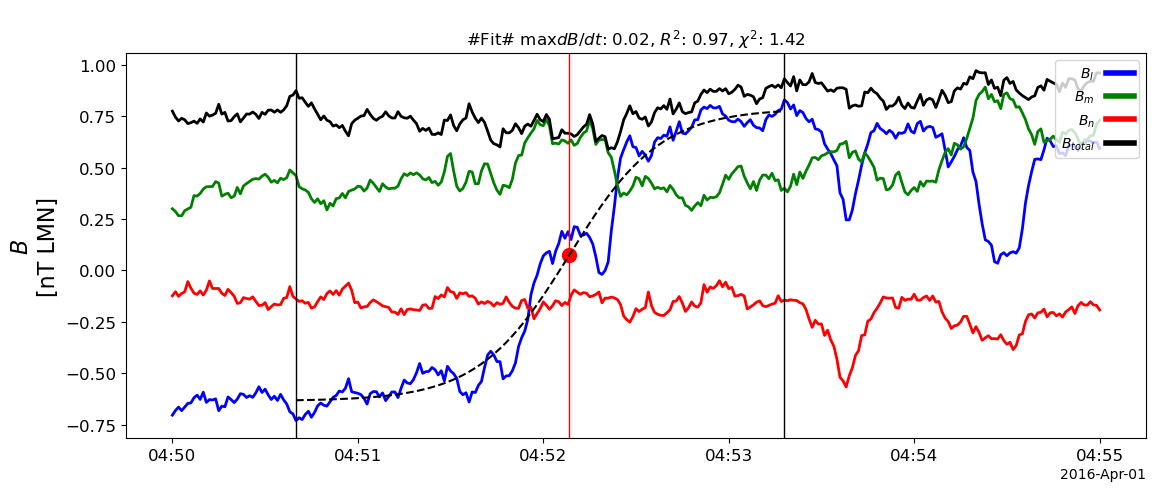

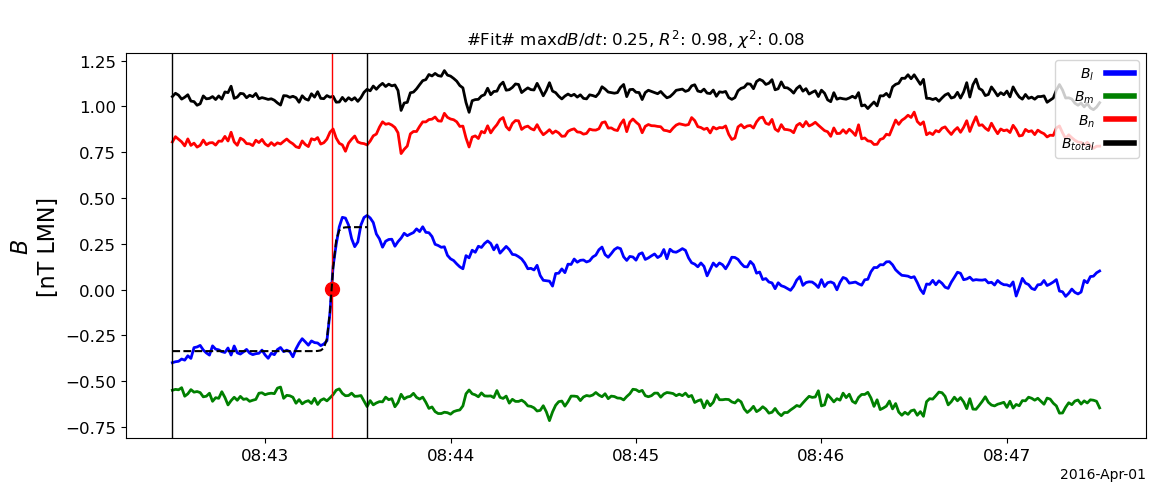

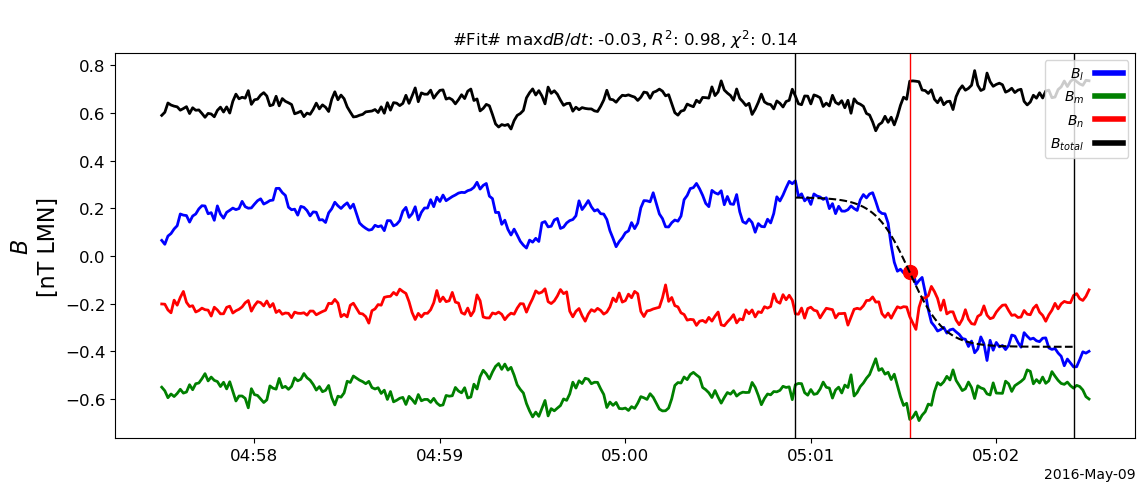

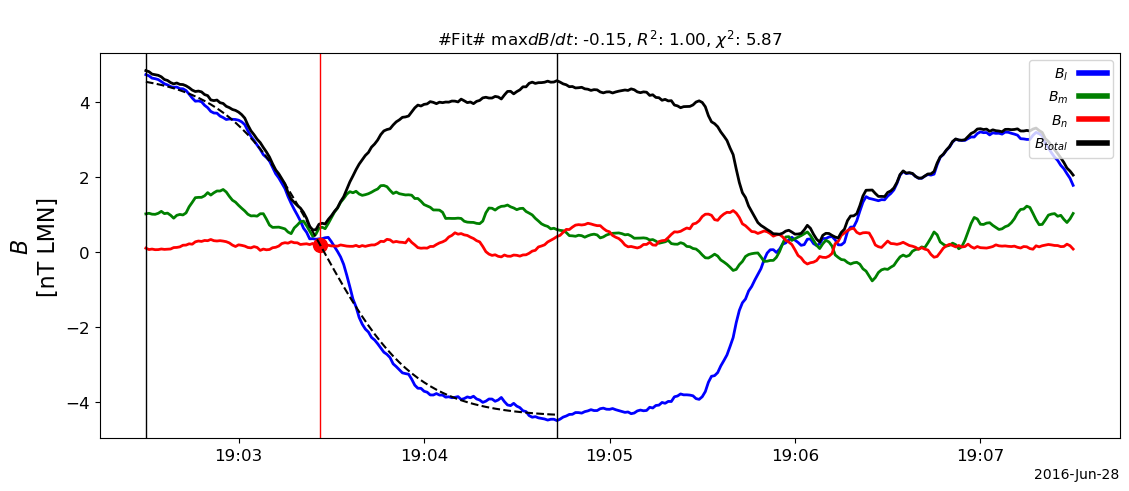

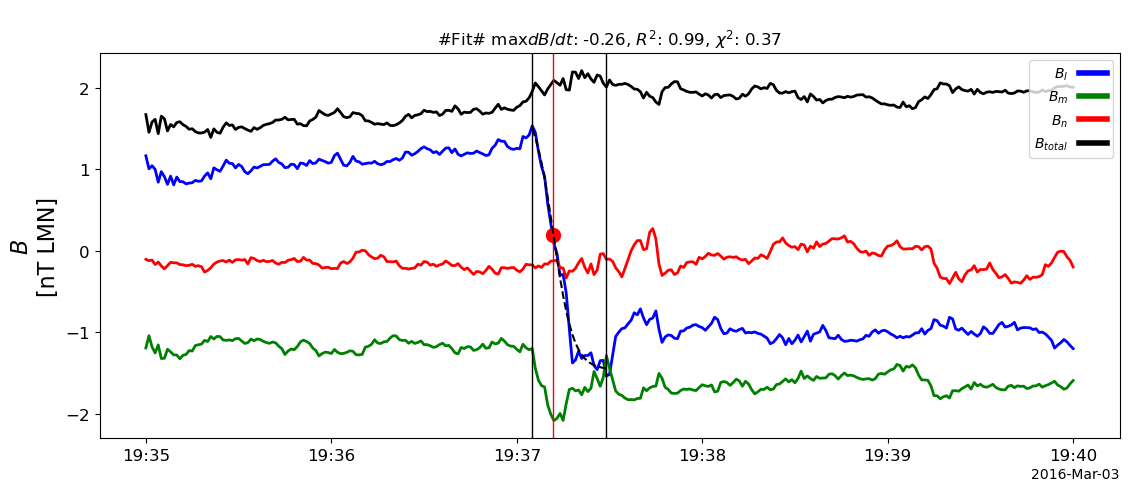

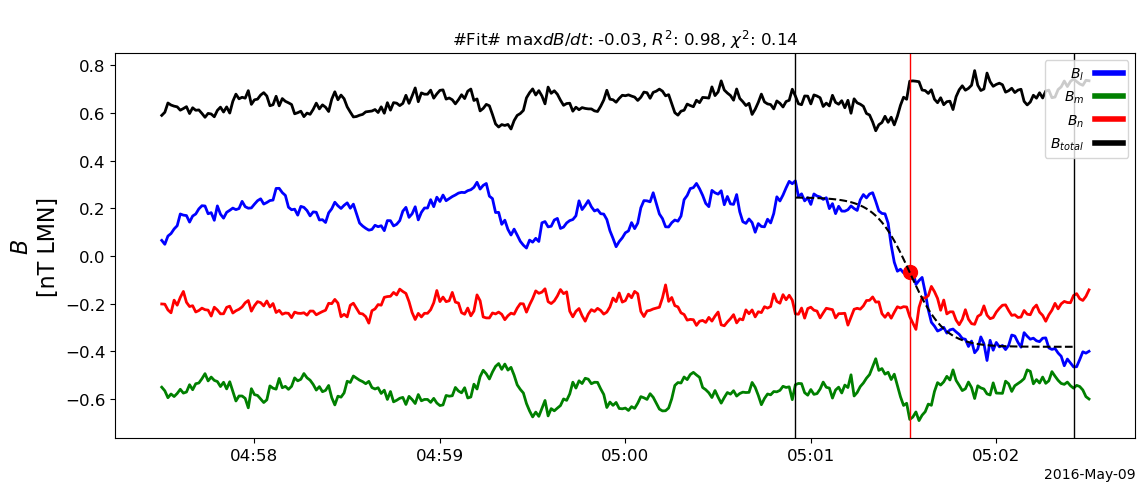

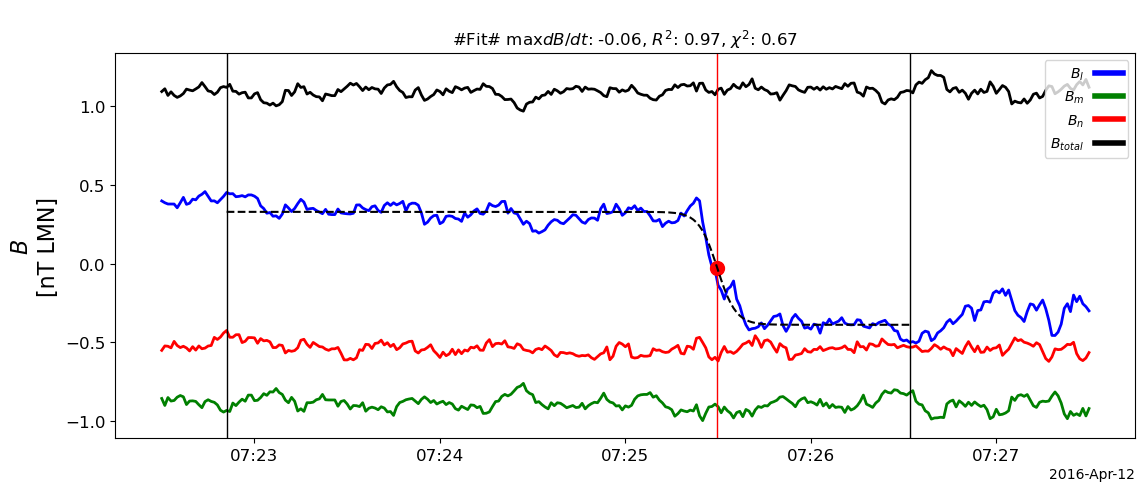

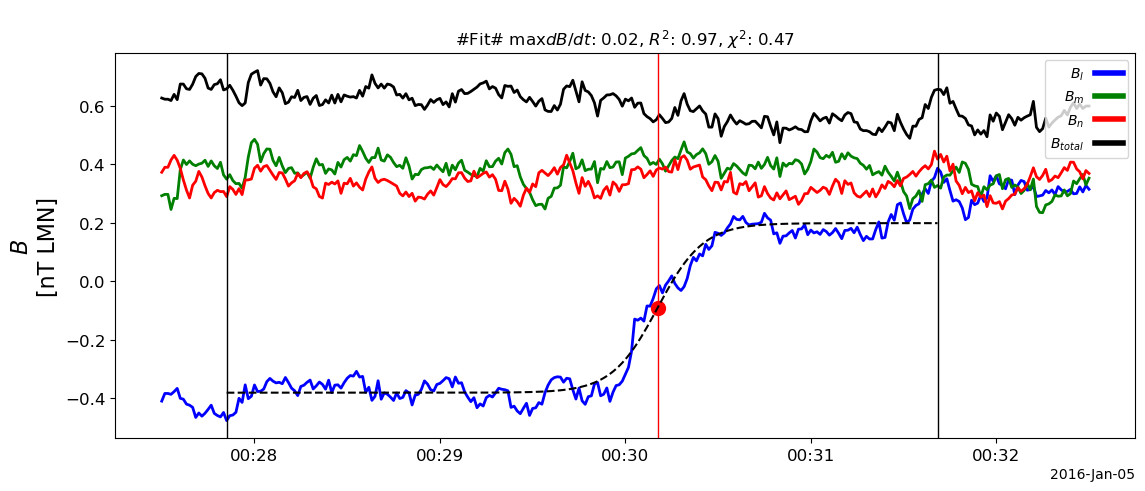

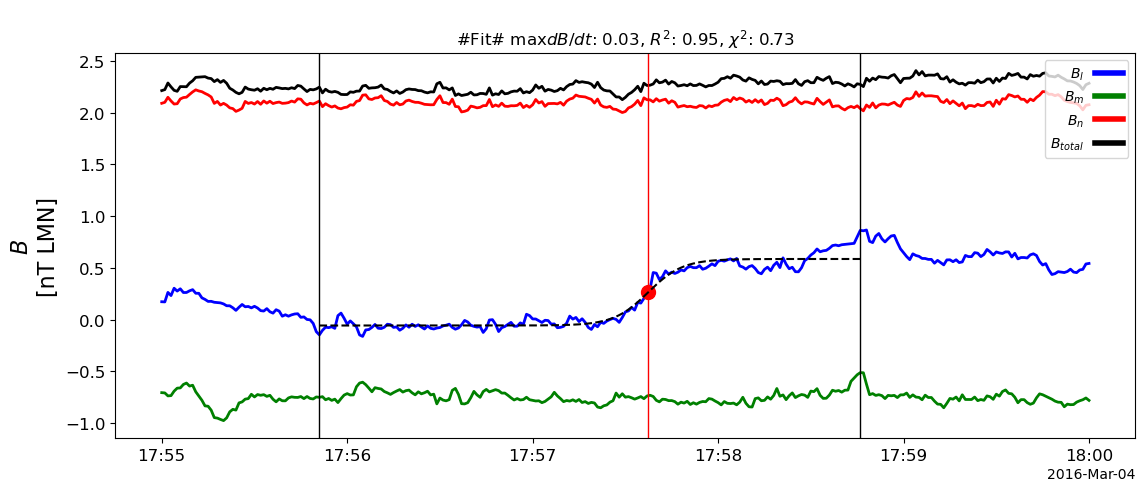

In [15]:
#| layout-ncol: 3
#| column: page
ids_ds.plot_candidates(num=20, plot_fit_data=True, predicates=(pl.col('fit.stat.rsquared') > 0.95))


## Processing the whole data

## Obsolete

### Estimate

1 day of data resampled by 1 sec is about 12 MB.

So 1 year of data is about 4 GB, and 6 years of JUNO Cruise data is about 24 GB.

Downloading rate is about 250 KB/s, so it will take about 3 days to download all the data.

In [ ]:
num_of_files = 6*365
jno_file_size = 12e3
thm_file_size = 40e3
files_size = jno_file_size + thm_file_size
downloading_rate = 250
processing_rate = 1/60

time_to_download = num_of_files * files_size / downloading_rate / 60 / 60
space_required = num_of_files * files_size / 1e6
time_to_process = num_of_files / processing_rate / 60 / 60

print(f"Time to download: {time_to_download:.2f} hours")
print(f"Disk space required: {space_required:.2f} GB")
print(f"Time to process: {time_to_process:.2f} hours")